In [15]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

In [16]:
def load_fold_data(experiment_dir, num_folds, epoch):
    """
    Generalized function to load fold data from a given experiment directory.

    Args:
        experiment_dir (str): The directory path where the experiment data is stored.
        num_folds (int): Number of folds (e.g., 3 for fold_0, fold_1, fold_2).
        epoch (int): Epoch number to be loaded (e.g., 0 for epoch_0).

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data of all folds with fold information.
    """
    dfs = []

    for fold in range(num_folds):
        file_path = os.path.join(
            experiment_dir, f"fold_{fold}_epoch_{epoch}_metrics.csv"
        )

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df["fold"] = fold
            dfs.append(df)
        else:
            print(f"Warning: File {file_path} does not exist.")

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        print("No valid files were loaded.")
        return pd.DataFrame()  # Return an empty DataFrame if no files were found

In [17]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles/register.csv")
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333111 entries, 0 to 333110
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   base_file_name    333111 non-null  object 
 1   file_path         333111 non-null  object 
 2   global_file_path  333111 non-null  object 
 3   resolution        333111 non-null  float64
 4   x                 333111 non-null  int64  
 5   y                 333111 non-null  int64  
 6   label_quality     333111 non-null  float64
 7   resolution_bin    333111 non-null  float64
 8   original          333111 non-null  bool   
 9   biome             333111 non-null  float64
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 23.2+ MB


In [4]:
run_metrics_0 = load_fold_data(
    "/net/home/jmoehring/experiments/50k_100e_vanilla_tversky_a03b07g2/", 1, 59
)
run_metrics_1 = load_fold_data(
    "/net/home/jmoehring/experiments/50k_100e_vanilla_tversky_a03b07g2/", 2, 59
)
run_metrics_2 = load_fold_data(
    "/net/home/jmoehring/experiments/50k_100e_vanilla_tversky_a03b07g2/", 3, 59
)

In [5]:
metrics_df = pd.concat([run_metrics_0, run_metrics_1, run_metrics_2], ignore_index=True)

In [6]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
metrics_df = metrics_df[
    (metrics_df[[f"precision_{t}" for t in thresholds]] != 0).any(axis=1)
    & (metrics_df[[f"recall_{t}" for t in thresholds]] != 0).any(axis=1)
    & (metrics_df[[f"f1_{t}" for t in thresholds]] != 0).any(axis=1)
]

In [7]:
metrics_df.groupby("fold").agg(
    {"precision_0.5": "mean", "recall_0.5": "mean", "f1_0.5": "mean"}
).reset_index()

,fold,precision_0.5,recall_0.5,f1_0.5
0,0,0.614945,0.403287,0.400214
1,1,0.673456,0.456150,0.455054
2,2,0.602945,0.436180,0.407593


In [8]:
metrics_df.agg(
    {"precision_0.5": "mean", "recall_0.5": "mean", "f1_0.5": "mean"}
).reset_index()

,index,0
0,precision_0.5,0.633146
1,recall_0.5,0.427913
2,f1_0.5,0.420758


In [ ]:
# average precision recall and f1 grouped by biome

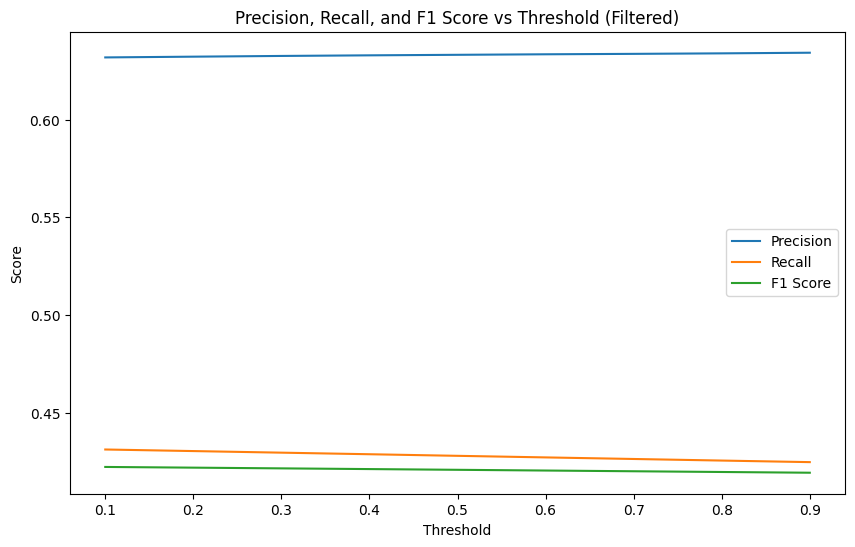

In [9]:
# Filtering the dataframe to exclude rows where all precision, recall, and f1 scores are 0 across all thresholds

plot_df = metrics_df
plot_df = plot_df[
    (plot_df[[f"precision_{t}" for t in thresholds]] != 0).any(axis=1)
    & (plot_df[[f"recall_{t}" for t in thresholds]] != 0).any(axis=1)
    & (plot_df[[f"f1_{t}" for t in thresholds]] != 0).any(axis=1)
]
# Recalculating mean precision, recall, and f1 scores for each threshold based on the filtered dataframe
mean_precision_filtered = plot_df[[f"precision_{t}" for t in thresholds]].mean(axis=0)
mean_recall_filtered = plot_df[[f"recall_{t}" for t in thresholds]].mean(axis=0)
mean_f1_filtered = plot_df[[f"f1_{t}" for t in thresholds]].mean(axis=0)

# Creating a new dataframe for plotting
plot_data_filtered = pd.DataFrame(
    {
        "threshold": thresholds,
        "mean_precision": mean_precision_filtered.values,
        "mean_recall": mean_recall_filtered.values,
        "mean_f1": mean_f1_filtered.values,
    }
)

# Now plotting using seaborn with the filtered data
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="threshold", y="mean_precision", data=plot_data_filtered, label="Precision"
)
sns.lineplot(x="threshold", y="mean_recall", data=plot_data_filtered, label="Recall")
sns.lineplot(x="threshold", y="mean_f1", data=plot_data_filtered, label="F1 Score")

plt.title("Precision, Recall, and F1 Score vs Threshold (Filtered)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [10]:
# join the register with the metrics
register_metrics = pd.merge(
    register_df, metrics_df, right_on="register_index", left_index=True
)

In [11]:
register_metrics.columns

Index(['base_file_name', 'file_path', 'global_file_path', 'resolution', 'x',
       'y', 'label_quality', 'resolution_bin', 'original', 'biome',
       'precision_0.1', 'precision_0.2', 'precision_0.3', 'precision_0.4',
       'precision_0.5', 'precision_0.6', 'precision_0.7', 'precision_0.8',
       'precision_0.9', 'recall_0.1', 'recall_0.2', 'recall_0.3', 'recall_0.4',
       'recall_0.5', 'recall_0.6', 'recall_0.7', 'recall_0.8', 'recall_0.9',
       'f1_0.1', 'f1_0.2', 'f1_0.3', 'f1_0.4', 'f1_0.5', 'f1_0.6', 'f1_0.7',
       'f1_0.8', 'f1_0.9', 'iou_0.1', 'iou_0.2', 'iou_0.3', 'iou_0.4',
       'iou_0.5', 'iou_0.6', 'iou_0.7', 'iou_0.8', 'iou_0.9', 'register_index',
       'epoch', 'fold'],
      dtype='object')

In [12]:
biome_dict = {
    1: "Tropical and Subtropical Moist Broadleaf Forests",
    2: "Tropical and Subtropical Dry Broadleaf Forests",
    3: "Tropical and Subtropical Coniferous Forests",
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    7: "Tropical and Subtropical Grasslands, Savannas, and Shrublands",
    8: "Temperate Grasslands, Savannas, and Shrublands",
    9: "Flooded Grasslands and Savannas",
    10: "Montane Grasslands and Shrublands",
    11: "Tundra",
    12: "Mediterranean Forests, Woodlands, and Scrub",
    13: "Deserts and Xeric Shrublands",
    14: "Mangroves",
}

In [13]:
register_metrics = register_metrics[register_metrics["resolution_bin"] != 0.28]

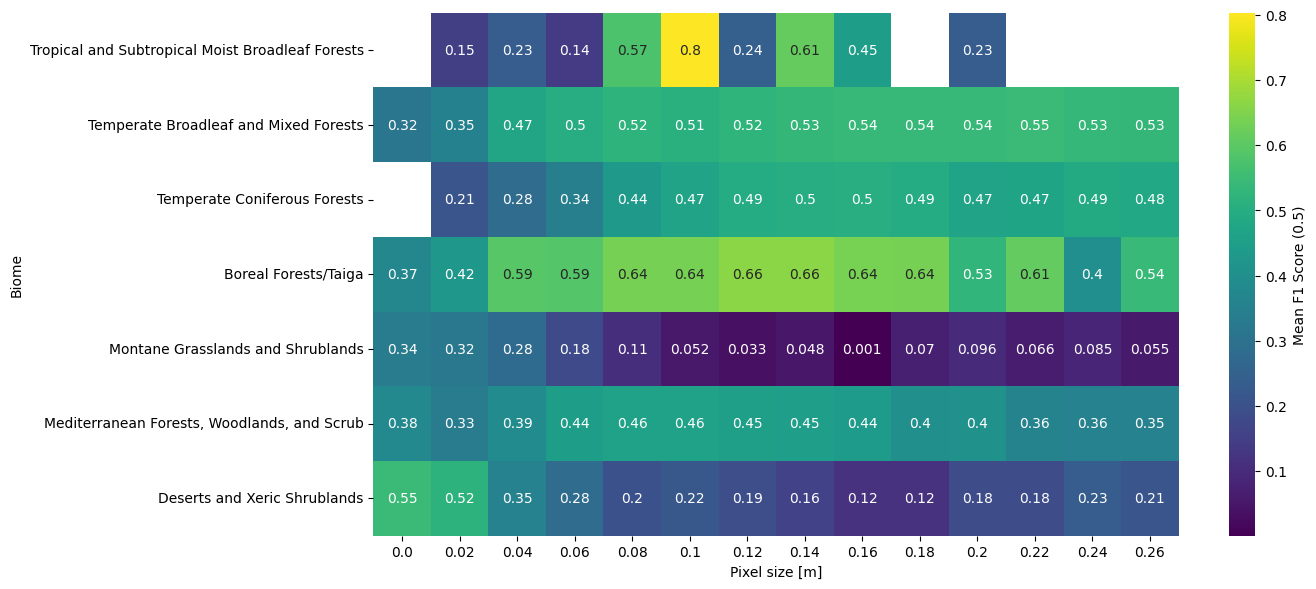

In [14]:
heat_df = register_metrics[
    (register_metrics[[f"precision_{t}" for t in thresholds]] != 0).any(axis=1)
    & (register_metrics[[f"recall_{t}" for t in thresholds]] != 0).any(axis=1)
    & (register_metrics[[f"f1_{t}" for t in thresholds]] != 0).any(axis=1)
]
# Group by 'biome' and 'resolution_bin', calculating the mean of 'f1_0.5'
heatmap_data = (
    heat_df.groupby(["biome", "resolution_bin"])["recall_0.5"].mean().unstack()
)

# use the biome_dict to replace the biome numbers with the biome names
heatmap_data.index = heatmap_data.index.map(biome_dict)

# roud to three decimal places
heatmap_data = heatmap_data.round(3)
# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data, cmap="viridis", annot=True, cbar_kws={"label": "Mean F1 Score (0.5)"}
)
plt.ylabel("Biome")
plt.xlabel("Pixel size [m]")
plt.tight_layout()

plt.savefig("/net/home/jmoehring/plots/heatmap_bl.png", dpi=400)
plt.show()

In [18]:
# avergae precision recall and f1 grouped by biome
mean_metrics = (
    heat_df.groupby("biome")
    .agg(
        {
            "precision_0.5": "mean",
            "recall_0.5": "mean",
            "f1_0.5": "mean",
        }
    )
    .reset_index()
)